In [1]:
import numpy as np
import time
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import train_test_split
from matplotlib import animation
import matplotlib.pyplot as plt
from IPython.display import HTML
import seaborn as sns
sns.set()

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
df = pd.read_csv('Iris.csv')
df.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


In [3]:
X = PCA(n_components=2).fit_transform(MinMaxScaler().fit_transform(df.iloc[:, 1:-1]))
Y = LabelEncoder().fit_transform(df.iloc[:, -1])
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)

In [4]:
class neuralnetwork:
    def __init__(self, id_, hidden_size = 64):
        self.W1 = np.random.randn(X.shape[1], hidden_size) / np.sqrt(X.shape[1])
        self.W2 = np.random.randn(hidden_size, hidden_size) / np.sqrt(hidden_size)
        self.W3 = np.random.randn(hidden_size, 3) / np.sqrt(hidden_size)
        self.fitness = 0
        self.id = id_

def sigmoid(X):
    return 1 / (1 + np.exp(-X))
    
def softmax(X):
    e_x = np.exp(X - np.max(X, axis=-1, keepdims=True))
    return e_x / np.sum(e_x, axis=-1, keepdims=True)

def feed_forward(X, nets):
    a1 = np.dot(X, nets.W1)
    z1 = sigmoid(a1)
    a2 = np.dot(z1, nets.W2)
    z2 = sigmoid(a2)
    a3 = np.dot(z2, nets.W3)
    return softmax(a3)

In [5]:
class NeuroEvolution:
    def __init__(self, population_size, mutation_rate, model_generator):
        self.population_size = population_size
        self.mutation_rate = mutation_rate
        self.model_generator = model_generator
        
    def _initialize_population(self):
        self.population = []
        for i in range(self.population_size):
            self.population.append(self.model_generator(i))
    
    def mutate(self, individual, scale=1.0):
        mutation_mask = np.random.binomial(1, p=self.mutation_rate, size=individual.W1.shape)
        individual.W1 += np.random.normal(loc=0, scale=scale, size=individual.W1.shape) * mutation_mask
        mutation_mask = np.random.binomial(1, p=self.mutation_rate, size=individual.W2.shape)
        individual.W2 += np.random.normal(loc=0, scale=scale, size=individual.W2.shape) * mutation_mask
        mutation_mask = np.random.binomial(1, p=self.mutation_rate, size=individual.W3.shape)
        individual.W3 += np.random.normal(loc=0, scale=scale, size=individual.W3.shape) * mutation_mask
        return individual
    
    def inherit_weights(self, parent, child):
        child.W1 = parent.W1.copy()
        child.W2 = parent.W2.copy()
        child.W3 = parent.W3.copy()
        return child
    
    def crossover(self, parent1, parent2):
        child1 = self.model_generator((parent1.id+1)*10)
        child1 = self.inherit_weights(parent1, child1)
        child2 = self.model_generator((parent2.id+1)*10)
        child2 = self.inherit_weights(parent2, child2)
        # first W
        n_neurons = child1.W1.shape[1]
        cutoff = np.random.randint(0, n_neurons)
        child1.W1[:, cutoff:] = parent2.W1[:, cutoff:].copy()
        child2.W1[:, cutoff:] = parent1.W1[:, cutoff:].copy()
        # second W
        n_neurons = child1.W2.shape[1]
        cutoff = np.random.randint(0, n_neurons)
        child1.W2[:, cutoff:] = parent2.W2[:, cutoff:].copy()
        child2.W2[:, cutoff:] = parent1.W2[:, cutoff:].copy()
        # third W
        n_neurons = child1.W3.shape[1]
        cutoff = np.random.randint(0, n_neurons)
        child1.W3[:, cutoff:] = parent2.W3[:, cutoff:].copy()
        child2.W3[:, cutoff:] = parent1.W3[:, cutoff:].copy()
        return child1, child2
        
    def calculate_fitness(self, X, Y):
        for i in range(self.population_size):
            logits = feed_forward(X, self.population[i])
            self.population[i].fitness = np.mean(np.argmax(logits,axis=1) == Y)
        
    def evolve(self, X, Y, generations=20, checkpoint= 5):
        self._initialize_population()
        n_winners = int(self.population_size * 0.4)
        n_parents = self.population_size - n_winners
        for epoch in range(generations):
            self.calculate_fitness(X, Y)
            sort_fitness = np.argsort([i.fitness for i in self.population])[::-1]
            self.population = [self.population[i] for i in sort_fitness]
            fittest_individual = self.population[0]
            if (epoch+1) % checkpoint == 0:
                print('epoch %d, fittest individual %d with accuracy %f'%(epoch+1, sort_fitness[0], 
                                                                          self.population[0].fitness))
            next_population = [self.population[i] for i in range(n_winners)]
            total_fitness = np.sum([i.fitness for i in self.population])
            parent_probabilities = [i.fitness / total_fitness for i in self.population]
            parents = np.random.choice(self.population, size=n_parents, p=parent_probabilities, replace=False)
            for i in np.arange(0, len(parents), 2):
                child1, child2 = self.crossover(parents[i], parents[i+1])
                next_population += [self.mutate(child1), self.mutate(child2)]
            self.population = next_population
        return fittest_individual

In [6]:
population_size = 100
generations = 100
mutation_rate = 0.1
neural_evolve = NeuroEvolution(population_size, mutation_rate, neuralnetwork)

In [7]:
fittest_nets = neural_evolve.evolve(X_train, Y_train, generations)

epoch 5, fittest individual 86 with accuracy 0.666667
epoch 10, fittest individual 0 with accuracy 0.666667
epoch 15, fittest individual 0 with accuracy 0.675000
epoch 20, fittest individual 0 with accuracy 0.675000
epoch 25, fittest individual 0 with accuracy 0.725000
epoch 30, fittest individual 0 with accuracy 0.725000
epoch 35, fittest individual 0 with accuracy 0.725000
epoch 40, fittest individual 0 with accuracy 0.725000
epoch 45, fittest individual 0 with accuracy 0.725000
epoch 50, fittest individual 0 with accuracy 0.725000
epoch 55, fittest individual 0 with accuracy 0.725000
epoch 60, fittest individual 0 with accuracy 0.725000
epoch 65, fittest individual 0 with accuracy 0.866667
epoch 70, fittest individual 0 with accuracy 0.866667
epoch 75, fittest individual 0 with accuracy 0.866667
epoch 80, fittest individual 0 with accuracy 0.866667
epoch 85, fittest individual 0 with accuracy 0.866667
epoch 90, fittest individual 0 with accuracy 0.866667
epoch 95, fittest individual

In [10]:
test_accuracy = np.mean(np.argmax(feed_forward(X_test, fittest_nets),axis=1) == Y_test)

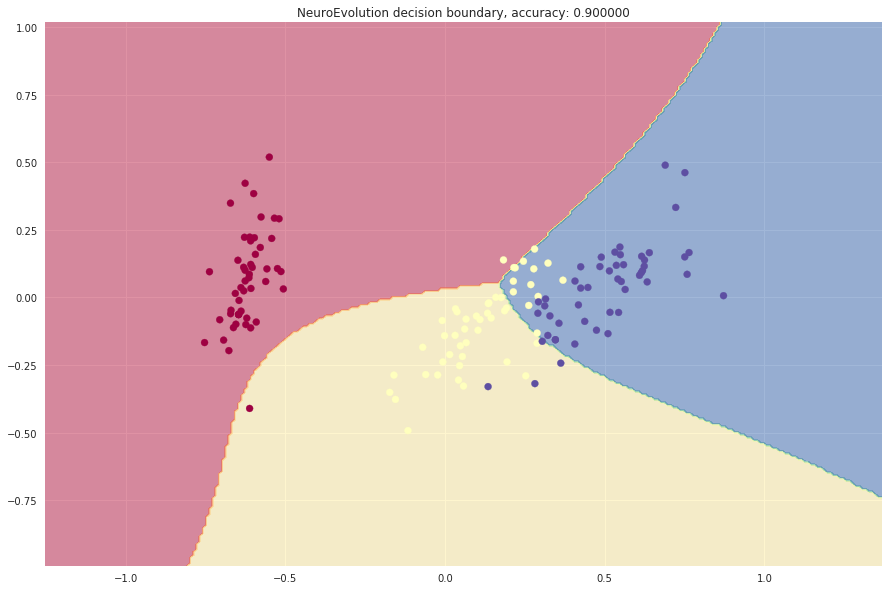

In [11]:
fig = plt.figure(figsize=(15,10))
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
h = 0.01
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
grid = np.c_[xx.ravel(), yy.ravel()]
Z = np.argmax(feed_forward(grid, fittest_nets),axis=1)
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha = 0.5)
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.Spectral)
plt.title('NeuroEvolution decision boundary, accuracy: %f'%(test_accuracy))
plt.show()